In [1]:
import findspark
findspark.init("/opt/manual/spark")

import pyspark
from pyspark.sql.types import * 
from pyspark.sql import SparkSession, functions as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidatorModel, ParamGridBuilder, CrossValidator

In [2]:
spark = SparkSession.builder \
    .appName("Spark Task") \
    .master("local[2]") \
    .enableHiveSupport() \
    .getOrCreate()

In [3]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [4]:
path = "/home/train/project_fin/KETI"
room_numbers = os.listdir(path)
room_numbers.remove("README.txt")

In [5]:
hdfs_base_path = "hdfs://localhost:9000/user/train/datasets/KETI/"

schema = StructType([StructField('Time',
                                  StringType(), True),
                    StructField('Value',
                                FloatType(), True),
                    StructField('Room',
                                StringType(), True)])

df_co2 = spark.createDataFrame(data = [],
                           schema = schema)
df_humidity = spark.createDataFrame(data = [],
                           schema = schema)
df_light = spark.createDataFrame(data = [],
                           schema = schema)
df_pir = spark.createDataFrame(data = [],
                           schema = schema)
df_temperature = spark.createDataFrame(data = [],
                           schema = schema)

for number in room_numbers:
    hdfs_whole_path = hdfs_base_path + number + "/"
    
    co2 = spark.read.format("csv") \
      .option("header", False) \
      .schema(schema) \
      .load(hdfs_whole_path + "co2.csv")
    
    df_co2 = df_co2.union(co2.withColumn("Room", F.lit(number)))
    
    humidity = spark.read.format("csv") \
      .option("header", False) \
      .schema(schema) \
      .load(hdfs_whole_path + "humidity.csv")
    
    df_humidity = df_humidity.union(humidity.withColumn("Room", F.lit(number)))
    
    light = spark.read.format("csv") \
      .option("header", False) \
      .schema(schema) \
      .load(hdfs_whole_path + "light.csv")
    
    df_light = df_light.union(light.withColumn("Room", F.lit(number)))
    
    temperature = spark.read.format("csv") \
      .option("header", False) \
      .schema(schema) \
      .load(hdfs_whole_path + "temperature.csv")
    
    df_temperature = df_temperature.union(temperature.withColumn("Room", F.lit(number)))
    
    pir = spark.read.format("csv") \
      .option("header", False) \
      .schema(schema) \
      .load(hdfs_whole_path + "pir.csv")
    
    df_pir = df_pir.union(pir.withColumn("Room", F.lit(number)))

In [6]:
df_co2

Time,Value,Room
1377299107,488.0,413
1377299108,495.0,413
1377299110,487.0,413
1377299127,496.0,413
1377299130,495.0,413
1377299134,500.0,413
1377299139,495.0,413
1377299144,498.0,413
1377299149,496.0,413
1377299154,496.0,413


In [7]:
nacounts = df_co2.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df_co2.columns]).toPandas()
nacounts

,Time,Value,Room
0,0,0,0


In [8]:
df_co2.describe()

summary,Time,Value,Room
count,6574008,6574008,6574008
mean,1.3776353446464927E9,411.00657635342094,578.8140258699461
stddev,197438.93946163714,103.51541277299566,125.11433241496981
min,1377274006,8.0,413
max,1378018681,1699.0,776


In [9]:
df_humidity.show(5)

+----------+-----+----+
|      Time|Value|Room|
+----------+-----+----+
|1377299107|45.34| 413|
|1377299108|45.34| 413|
|1377299126|45.34| 413|
|1377299131|45.31| 413|
|1377299136|45.34| 413|
+----------+-----+----+
only showing top 5 rows



In [10]:
nacounts = df_humidity.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df_humidity.columns]).toPandas()
nacounts

,Time,Value,Room
0,0,0,0


In [11]:
df_humidity.describe()

summary,Time,Value,Room
count,6571465,6571465,6571465
mean,1.377634784039541E9,56.7477052709077,578.8782723440254
stddev,197935.7390174003,4.307900371726986,125.02399167174264
min,1377292829,-500.96,413
max,1378018369,71.91,776


In [12]:
df_light

Time,Value,Room
1377299107,97.0,413
1377299108,97.0,413
1377299126,97.0,413
1377299131,97.0,413
1377299136,97.0,413
1377299141,96.0,413
1377299146,96.0,413
1377299151,96.0,413
1377299156,96.0,413
1377299161,97.0,413


In [13]:
nacounts = df_light.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df_light.columns]).toPandas()
nacounts

,Time,Value,Room
0,0,0,0


In [14]:
df_light.describe()

summary,Time,Value,Room
count,6571463,6571463,6571463
mean,1.3776347839036963E9,82.26155652097562,578.8782745160211
stddev,197935.66398888963,310.1547096557644,125.02400109924437
min,1377292829,0.0,413
max,1378018369,30551.0,776


In [15]:
df_temperature

Time,Value,Room
1377299107,23.93,413
1377299108,23.94,413
1377299126,23.93,413
1377299131,23.93,413
1377299136,23.92,413
1377299141,23.92,413
1377299146,23.92,413
1377299151,23.93,413
1377299156,23.93,413
1377299161,23.93,413


In [16]:
nacounts = df_temperature.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df_temperature.columns]).toPandas()
nacounts

,Time,Value,Room
0,0,0,0


In [17]:
df_temperature.describe()

summary,Time,Value,Room
count,6571505,6571505,6571505
mean,1.3776347835199444E9,23.970198924024434,578.8783621943661
stddev,197934.3095529147,21.191679563973466,125.02389562585525
min,1377292829,-40.1,413
max,1378018369,579.27,776


In [18]:
df_pir

Time,Value,Room
1377299108,0.0,413
1377299126,0.0,413
1377299127,0.0,413
1377299130,0.0,413
1377299139,0.0,413
1377299149,0.0,413
1377299159,0.0,413
1377299169,0.0,413
1377299179,0.0,413
1377299189,0.0,413


In [19]:
nacounts = df_pir.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df_pir.columns]).toPandas()
nacounts

,Time,Value,Room
0,0,0,0


In [20]:
df_pir.describe()

summary,Time,Value,Room
count,3593953,3593953,3593953
mean,1.3776585765605793E9,1.7543006266359076,579.7942800863254
stddev,207686.75581655867,19.345402086673538,125.1627621731147
min,1377270000,0.0,413
max,1378018739,34456.0,776


In [21]:
df_pir.printSchema()

root
 |-- Time: string (nullable = true)
 |-- Value: float (nullable = true)
 |-- Room: string (nullable = true)



In [22]:
def join_with_aliases(left, right, on, how, right_prefix):
    renamed_right = right.selectExpr(
        [
            col + f" as {col}_{right_prefix}"
            for col in df_humidity.columns
            if col not in on
        ]
        + on
    )
    right_on = [f"{x}{right_prefix}" for x in on]
    return left.join(renamed_right, on=on, how=how)

In [23]:
co2

co2_hum = join_with_aliases(
   left=df_co2,
   right=df_humidity,
   on=["Room","Time"],
   how="inner",
   right_prefix="humidity"
)

co2_hum_temperature = join_with_aliases(
   left=co2_hum,
   right=df_temperature,
   on=["Room","Time"],
   how="inner",
   right_prefix="temperature"
)

co2_hum_temperature_light = join_with_aliases(
   left=co2_hum_temperature,
   right=df_light,
   on=["Room","Time"],
   how="inner",
   right_prefix="light"
)

co2_hum_temperature_light_pir = join_with_aliases(
   left=co2_hum_temperature_light,
   right=df_pir,
   on=["Room","Time"],
   how="inner",
   right_prefix="pir"
)

co2_hum_temperature_light_pir

Room,Time,Value,Value_humidity,Value_temperature,Value_light,Value_pir
415,1377650743,611.0,54.61,24.08,61.0,0.0
415,1377656833,460.0,55.58,23.71,24.0,0.0
415,1377657993,472.0,55.92,23.63,9.0,0.0
415,1377660833,465.0,56.57,23.47,4.0,0.0
415,1377666003,477.0,57.41,23.28,4.0,0.0
415,1377667093,462.0,57.41,23.28,4.0,0.0
415,1377692382,462.0,58.33,22.61,4.0,0.0
415,1377694542,454.0,58.3,22.56,3.0,0.0
415,1377695762,460.0,58.33,22.52,4.0,0.0
415,1377696862,455.0,58.39,22.51,4.0,0.0


In [24]:
co2_hum_temperature_light_pir = co2_hum_temperature_light_pir.withColumnRenamed("Value", "Value_co2")

In [25]:
co2_hum_temperature_light_pir

Room,Time,Value_co2,Value_humidity,Value_temperature,Value_light,Value_pir
415,1377650743,611.0,54.61,24.08,61.0,0.0
415,1377656833,460.0,55.58,23.71,24.0,0.0
415,1377657993,472.0,55.92,23.63,9.0,0.0
415,1377660833,465.0,56.57,23.47,4.0,0.0
415,1377666003,477.0,57.41,23.28,4.0,0.0
415,1377667093,462.0,57.41,23.28,4.0,0.0
415,1377692382,462.0,58.33,22.61,4.0,0.0
415,1377694542,454.0,58.3,22.56,3.0,0.0
415,1377695762,460.0,58.33,22.52,4.0,0.0
415,1377696862,455.0,58.39,22.51,4.0,0.0


In [26]:
co2_hum_temperature_light_pir.count()

135386

In [27]:
co2_hum_temperature_light_pir_ts = co2_hum_temperature_light_pir.withColumn('Time', F.from_unixtime('Time').cast(TimestampType()))

In [28]:
co2_hum_temperature_light_pir_ts

Room,Time,Value_co2,Value_humidity,Value_temperature,Value_light,Value_pir
415,2013-08-28 03:45:43,611.0,54.61,24.08,61.0,0.0
415,2013-08-28 05:27:13,460.0,55.58,23.71,24.0,0.0
415,2013-08-28 05:46:33,472.0,55.92,23.63,9.0,0.0
415,2013-08-28 06:33:53,465.0,56.57,23.47,4.0,0.0
415,2013-08-28 08:00:03,477.0,57.41,23.28,4.0,0.0
415,2013-08-28 08:18:13,462.0,57.41,23.28,4.0,0.0
415,2013-08-28 15:19:42,462.0,58.33,22.61,4.0,0.0
415,2013-08-28 15:55:42,454.0,58.3,22.56,3.0,0.0
415,2013-08-28 16:16:02,460.0,58.33,22.52,4.0,0.0
415,2013-08-28 16:34:22,455.0,58.39,22.51,4.0,0.0


In [29]:
co2_hum_temperature_light_pir_ts_sorted = co2_hum_temperature_light_pir_ts.sort(co2_hum_temperature_light_pir_ts.Time)

In [30]:
co2_hum_temperature_light_pir_ts_sorted

Room,Time,Value_co2,Value_humidity,Value_temperature,Value_light,Value_pir
511,2013-08-24 02:04:53,387.0,52.75,22.62,252.0,0.0
644,2013-08-24 02:04:57,465.0,52.4,22.8,165.0,0.0
656A,2013-08-24 02:04:57,579.0,49.9,24.37,176.0,30.0
648,2013-08-24 02:04:57,175.0,50.32,23.32,191.0,0.0
558,2013-08-24 02:05:01,423.0,53.51,23.11,3.0,0.0
564,2013-08-24 02:05:01,434.0,49.94,24.08,11.0,29.0
666,2013-08-24 02:05:05,437.0,49.39,24.14,148.0,0.0
664,2013-08-24 02:05:05,347.0,50.03,23.64,3.0,0.0
668,2013-08-24 02:05:05,421.0,49.06,24.81,1977.0,0.0
656B,2013-08-24 02:05:05,538.0,46.49,25.26,102.0,30.0


In [31]:
data = co2_hum_temperature_light_pir_ts_sorted.alias('data')

In [32]:
data

Room,Time,Value_co2,Value_humidity,Value_temperature,Value_light,Value_pir
511,2013-08-24 02:04:53,387.0,52.75,22.62,252.0,0.0
656A,2013-08-24 02:04:57,579.0,49.9,24.37,176.0,30.0
644,2013-08-24 02:04:57,465.0,52.4,22.8,165.0,0.0
648,2013-08-24 02:04:57,175.0,50.32,23.32,191.0,0.0
564,2013-08-24 02:05:01,434.0,49.94,24.08,11.0,29.0
558,2013-08-24 02:05:01,423.0,53.51,23.11,3.0,0.0
668,2013-08-24 02:05:05,421.0,49.06,24.81,1977.0,0.0
656B,2013-08-24 02:05:05,538.0,46.49,25.26,102.0,30.0
664,2013-08-24 02:05:05,347.0,50.03,23.64,3.0,0.0
666,2013-08-24 02:05:05,437.0,49.39,24.14,148.0,0.0


In [33]:
data = data.withColumn('Value_pir',F.when(data.Value_pir > 0, 1).otherwise(0))
data

Room,Time,Value_co2,Value_humidity,Value_temperature,Value_light,Value_pir
511,2013-08-24 02:04:53,387.0,52.75,22.62,252.0,0
644,2013-08-24 02:04:57,465.0,52.4,22.8,165.0,0
656A,2013-08-24 02:04:57,579.0,49.9,24.37,176.0,1
648,2013-08-24 02:04:57,175.0,50.32,23.32,191.0,0
564,2013-08-24 02:05:01,434.0,49.94,24.08,11.0,1
558,2013-08-24 02:05:01,423.0,53.51,23.11,3.0,0
656B,2013-08-24 02:05:05,538.0,46.49,25.26,102.0,1
668,2013-08-24 02:05:05,421.0,49.06,24.81,1977.0,0
664,2013-08-24 02:05:05,347.0,50.03,23.64,3.0,0
666,2013-08-24 02:05:05,437.0,49.39,24.14,148.0,0


In [34]:
data.printSchema()

root
 |-- Room: string (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Value_co2: float (nullable = true)
 |-- Value_humidity: float (nullable = true)
 |-- Value_temperature: float (nullable = true)
 |-- Value_light: float (nullable = true)
 |-- Value_pir: integer (nullable = false)



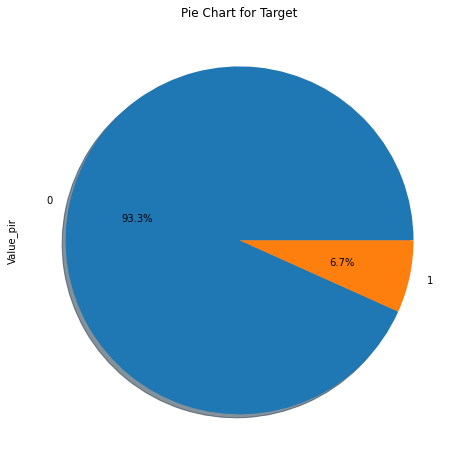

In [35]:
data.select(F.col("Value_pir")).toPandas()['Value_pir'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True, figsize=(8,8))
plt.title('Pie Chart for Target')
plt.show()

In [36]:
data.describe()

summary,Room,Value_co2,Value_humidity,Value_temperature,Value_light,Value_pir
count,135386,135386,135386,135386,135386,135386
mean,595.1545244267818,399.27423071809494,56.8917659204558,23.415894764528037,140.57186119687412,0.06719306279822138
stddev,115.1693984614636,119.0818582874651,3.611998227037885,11.836374629046169,470.6867628720148,0.2503569812734329
min,413,62.0,42.12,20.2,0.0,0
max,776,1223.0,71.29,579.27,2397.0,1


In [37]:
data = data.withColumnRenamed("Value_pir","label")

In [38]:
assembler = VectorAssembler(inputCols=['Value_co2','Value_humidity','Value_temperature','Value_light'],
                           outputCol = "vector_assembler_cols",
                           handleInvalid="skip")

In [39]:
scaler = StandardScaler().setInputCol("vector_assembler_cols").setOutputCol("features")

In [40]:
estimator = DecisionTreeClassifier() \
.setFeaturesCol("features") \
.setLabelCol("label")

In [41]:
pipeline_obj = Pipeline().setStages([assembler, scaler, estimator])

In [42]:
train, valid, test = data.randomSplit([0.6,0.3,0.1], seed=100)

In [43]:
pipeline_model = pipeline_obj.fit(train)

In [44]:
paramGrid = ParamGridBuilder() \
.addGrid(estimator.maxDepth, [4,8]) \
.build()

In [45]:
crossval = CrossValidator(estimator=pipeline_obj,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2) 

In [46]:
cvModel = crossval.fit(train)

In [47]:
bestModel = cvModel.bestModel

In [48]:
evaluator = BinaryClassificationEvaluator()

In [49]:
evaluator.getMetricName()

'areaUnderROC'

In [50]:
evaluator.evaluate(bestModel.transform(valid))

0.8748197785841121

In [51]:
valid

Room,Time,Value_co2,Value_humidity,Value_temperature,Value_light,label
415,2013-08-28 16:50:42,450.0,58.55,22.49,5.0,0
415,2013-08-28 17:29:22,463.0,58.73,22.48,13.0,0
417,2013-08-29 06:40:57,345.0,59.19,23.52,3.0,0
419,2013-08-30 08:50:01,449.0,60.86,22.86,26.0,0
423,2013-08-26 20:02:09,511.0,53.85,23.93,42.0,1
423,2013-08-27 03:13:03,460.0,52.27,24.17,4.0,0
423,2013-08-27 18:26:01,354.0,49.26,24.14,3.0,0
424,2013-08-29 05:54:43,396.0,55.64,24.32,2.0,0
424,2013-08-29 13:40:11,381.0,57.44,23.74,3.0,0
424,2013-08-29 15:36:01,381.0,57.41,23.6,4.0,0


In [52]:
transformed_df = bestModel.transform(valid)
transformed_df

Room,Time,Value_co2,Value_humidity,Value_temperature,Value_light,label,vector_assembler_cols,features,rawPrediction,probability,prediction
415,2013-08-28 16:50:42,450.0,58.55,22.49,5.0,0,"[450.0,58.5499992...",[3.77122823427980...,"[11662.0,48.0]",[0.99590093936806...,0.0
415,2013-08-28 17:29:22,463.0,58.73,22.48,13.0,0,"[463.0,58.7299995...",[3.88017482771455...,"[5691.0,44.0]",[0.99232781168265...,0.0
417,2013-08-29 06:40:57,345.0,59.19,23.52,3.0,0,"[345.0,59.1899986...",[2.89127497961451...,"[36062.0,9.0]",[0.99975049208505...,0.0
419,2013-08-30 08:50:01,449.0,60.86,22.86,26.0,0,"[449.0,60.8600006...",[3.76284772709251...,"[1719.0,316.0]",[0.84471744471744...,0.0
423,2013-08-26 20:02:09,511.0,53.85,23.93,42.0,1,"[511.0,53.8499984...","[4.2824391727044,...","[118.0,471.0]",[0.20033955857385...,1.0
423,2013-08-27 03:13:03,460.0,52.27,24.17,4.0,0,"[460.0,52.2700004...",[3.85503330615268...,"[11662.0,48.0]",[0.99590093936806...,0.0
423,2013-08-27 18:26:01,354.0,49.26,24.14,3.0,0,"[354.0,49.2599983...",[2.96669954430011...,"[36062.0,9.0]",[0.99975049208505...,0.0
424,2013-08-29 05:54:43,396.0,55.64,24.32,2.0,0,"[396.0,55.6399993...",[3.31868084616622...,"[36062.0,9.0]",[0.99975049208505...,0.0
424,2013-08-29 13:40:11,381.0,57.44,23.74,3.0,0,"[381.0,57.4399986...",[3.19297323835690...,"[36062.0,9.0]",[0.99975049208505...,0.0
424,2013-08-29 15:36:01,381.0,57.41,23.6,4.0,0,"[381.0,57.4099998...",[3.19297323835690...,"[36062.0,9.0]",[0.99975049208505...,0.0


In [53]:
bestModel.write().overwrite().save("~/saved_models/Clf_Tuned_Decision_Tree")

In [54]:
test = test.drop('label')
test

Room,Time,Value_co2,Value_humidity,Value_temperature,Value_light
415,2013-08-28 06:33:53,465.0,56.57,23.47,4.0
417,2013-08-28 23:07:38,441.0,57.84,23.39,84.0
419,2013-08-31 00:12:08,711.0,59.77,23.58,118.0
423,2013-08-31 12:51:46,356.0,58.39,22.85,3.0
424,2013-08-27 14:20:15,389.0,48.48,24.46,4.0
424,2013-08-29 14:12:51,394.0,57.41,23.71,4.0
442,2013-08-29 19:26:33,451.0,58.42,23.51,5.0
446,2013-08-28 12:18:58,463.0,58.61,22.7,2.0
448,2013-08-28 23:57:41,466.0,58.85,23.22,4.0
448,2013-08-29 06:17:30,369.0,60.07,23.31,4.0


In [55]:
test_transformed_df = bestModel.transform(test)
test_transformed_df

Room,Time,Value_co2,Value_humidity,Value_temperature,Value_light,vector_assembler_cols,features,rawPrediction,probability,prediction
415,2013-08-28 06:33:53,465.0,56.57,23.47,4.0,"[465.0,56.5699996...",[3.89693584208913...,"[11662.0,48.0]",[0.99590093936806...,0.0
417,2013-08-28 23:07:38,441.0,57.84,23.39,84.0,"[441.0,57.8400001...",[3.69580366959420...,"[1719.0,316.0]",[0.84471744471744...,0.0
419,2013-08-31 00:12:08,711.0,59.77,23.58,118.0,"[711.0,59.7700004...",[5.95854061016209...,"[1.0,0.0]","[1.0,0.0]",0.0
423,2013-08-31 12:51:46,356.0,58.39,22.85,3.0,"[356.0,58.3899993...",[2.98346055867468...,"[36062.0,9.0]",[0.99975049208505...,0.0
424,2013-08-27 14:20:15,389.0,48.48,24.46,4.0,"[389.0,48.4799995...",[3.26001729585520...,"[36062.0,9.0]",[0.99975049208505...,0.0
424,2013-08-29 14:12:51,394.0,57.41,23.71,4.0,"[394.0,57.4099998...",[3.30191983179165...,"[36062.0,9.0]",[0.99975049208505...,0.0
442,2013-08-29 19:26:33,451.0,58.42,23.51,5.0,"[451.0,58.4199981...",[3.77960874146709...,"[11662.0,48.0]",[0.99590093936806...,0.0
446,2013-08-28 12:18:58,463.0,58.61,22.7,2.0,"[463.0,58.6100006...",[3.88017482771455...,"[11662.0,48.0]",[0.99590093936806...,0.0
448,2013-08-28 23:57:41,466.0,58.85,23.22,4.0,"[466.0,58.8499984...",[3.90531634927642...,"[11662.0,48.0]",[0.99590093936806...,0.0
448,2013-08-29 06:17:30,369.0,60.07,23.31,4.0,"[369.0,60.0699996...",[3.09240715210944...,"[36062.0,9.0]",[0.99975049208505...,0.0


In [56]:
test.coalesce(1).write.csv(path='file:///home/train/project_fin/test.csv', mode="overwrite", header="true")

In [57]:
spark.stop()